<a href="https://colab.research.google.com/github/Madhusti-D/Hardware_Security/blob/main/LeNET5_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from google.colab import files
import time
import random
#Import test data
from torchvision import datasets
import torchvision.transforms as transforms

In [ ]:


batch_size = 64
train_loader = datasets.MNIST(root = 'data', train = True, download = True)
test_loader = datasets.MNIST(root = 'data', train = False, download = True)



In [ ]:
print('length of testing data :', len(test_loader))
print('length of training data:',len(train_loader))

length of testing data : 10000
length of training data: 60000


In [ ]:
# import MNIST train and test datasets - as Tensors
train_data = datasets.MNIST(root = "data",
                               train = True,
                               download = True,
                               transform = transforms.Compose([
                                   transforms.ToTensor()]))
test_data = datasets.MNIST(root = "data",
                              train = False,
                              download = True,
                              transform = transforms.Compose([
                                  transforms.ToTensor()]))

In [ ]:
#creating subset of data

training_dataset,validation_dataset   = random_split(train_data,[50000, 10000])

In [ ]:
training_set = DataLoader(training_dataset,batch_size=batch_size, shuffle = True)
validation_set = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)
test_set = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
val_data_size = len(validation_dataset)
print(val_data_size)

10000


In [ ]:
#Transforms added to resize MNIST 28x28 to be same as SVHN 32x32

train_normal = datasets.MNIST(root = "data", train = True, download = True,
                              transform = transforms.Compose([
                                  transforms.Resize(32),
                                  transforms.ToTensor()
                              ]))
test_normal = datasets.MNIST(root = "data", train = True, download = True,
                                   transform = transforms.Compose([
                                      transforms.Resize(32),
                                      transforms.ToTensor()
                                   ]))

In [ ]:
training_normal_dataset,validation_normal_dataset   = random_split(train_normal,[50000, 10000])
val_data_normal_size = len(validation_normal_dataset)
print(val_data_normal_size)

training_normal_set = DataLoader(training_normal_dataset,batch_size=batch_size, shuffle = True)
validation_normal_set = DataLoader(validation_normal_dataset, batch_size = batch_size, shuffle = True)
test_normal_set = DataLoader(test_normal, batch_size = batch_size, shuffle = True)

10000


In [ ]:
import torch.nn.functional as F

In [ ]:
#Neural Network model

class LeNet(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1)

        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,10)


    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size = 2, stride =2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size = 2, stride =2)
      x = self.conv3(x)
      x = F.relu(x)

      x = x.view(x.shape[0], -1) #Flatten/reshape

      x = self.fc1(x)
      x = F.relu(x)

      x = self.fc2(x)



      return x


In [ ]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
conv3.weight torch.Size([120, 16, 5, 5]) True
conv3.bias torch.Size([120]) True
fc1.weight torch.Size([84, 120]) True
fc1.bias torch.Size([84]) True
fc2.weight torch.Size([10, 84]) True
fc2.bias torch.Size([10]) True


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # use GPU or CPU for training

##Training the Neural Network Model

In [ ]:
def accuracy(ypred, target):
    preds = ypred.argmax(1, keepdim = True)
    total = preds.shape[0]
    correct = preds.eq(target.view_as(preds)).sum()
    acc = correct.float() / total
    return acc

def train(model, train_iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total_step = len(train_iterator)
    for data in train_iterator:
        X, target = data                          # data is a list of [inputs, target]

        # Run the forward pass
        output = model(X)
        loss = criterion(output, target)
        epoch_loss += loss.item()

        # Backprop and optimize
        optimizer.zero_grad()                     # zeroes the gradient buffers of all parameters
        loss.backward()
        optimizer.step()

        # Track accuracy
        acc = accuracy(output, target)
        epoch_acc += acc.item()

    return epoch_loss / total_step, epoch_acc / total_step

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
EPOCHS = 10
loss_norm = []

for epoch in range(EPOCHS):                       # loop over the dataset multiple times
        start_time = time.time()
        train_loss, train_acc = train(net, training_normal_set, optimizer, criterion)
        loss_norm.append(train_loss)
        end_time = time.time()
        mins, secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

        if train_loss == 0:
            break

Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 0.640 | Train Acc: 78.53%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.090 | Train Acc: 97.20%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.060 | Train Acc: 98.11%
Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 0.046 | Train Acc: 98.55%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.037 | Train Acc: 98.82%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.031 | Train Acc: 98.97%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.026 | Train Acc: 99.18%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.023 | Train Acc: 99.26%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.019 | Train Acc: 99.35%
Epoch: 10 | Epoch Time: 0m 23s
	Train Loss: 0.016 | Train Acc: 99.47%


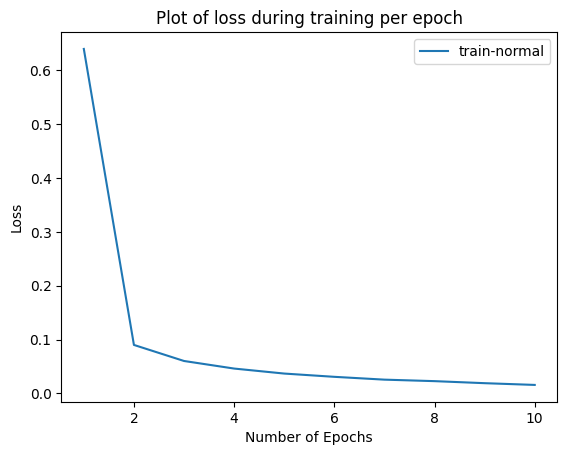

In [ ]:
x = range(1,EPOCHS+1)
y1 = loss_norm
plt.plot(x, y1, label="train-normal")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title("Plot of loss during training per epoch")
plt.legend()

## Saving the model or network as .pt file


In [ ]:
print("Our model: \n\n", net, '\n')
print("The state dict keys: \n\n", net.state_dict().keys())

Our model: 

 LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [ ]:
torch.save(net.state_dict(),'network.pt')

#download network file
files.download('network.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Load state dict parameters
state_dict = torch.load('network.pt')
print(state_dict.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


##Loading the state_dict() parameters to the network

In [ ]:
#To load the state dict in to the network, we need to use model.load_state_dict(state_dict)
# In my network I used net as the variable name instead of model name
net.load_state_dict(state_dict)

<All keys matched successfully>

##Testing the neural network

In [ ]:
def test(model, test_iterator, criterion):
    correct_idx = []
    wrong_idx = []
    test_dict = {}
    preds = []

    model.eval()
    test_loss = 0
    correct = 0
    total_step = len(test_iterator)
    with torch.no_grad():
        for i, data in enumerate(test_iterator):
            X, target = data
            test_dict[i] = (X, target)

            # Run the forward pass
            output = model(X)
            loss = criterion(output, target)
            test_loss += loss.item()

            # Track accuracy
            acc = accuracy(output, target)
            correct += acc.item()

            # Store index of correct and wrong predictions
            pred = output.argmax(dim=1, keepdim=True)
            preds.append(pred)
            c = [i for i, val in enumerate(pred.eq(target.view_as(pred))) if (val==True)]
            w = [i for i, val in enumerate(pred.eq(target.view_as(pred))) if (val==False)]
            correct_idx.append(c)
            wrong_idx.append(w)

    return test_loss / total_step, correct / total_step, correct_idx, wrong_idx, test_dict, preds

In [ ]:
test_loss, test_acc, c_id, w_id, test_dict, preds = test(net, test_normal_set, criterion)
print(f'\t No Augmentation-- Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	 No Augmentation-- Test Loss: 0.019 | Test Acc: 99.45%


##Visualizing the predictions

In [ ]:
print(f"Total number of batches: {len(preds)}")

# finding batch with most wrong predictions
w_lens =[]
wrong_idx = np.array(w_id)
for i, w_i in enumerate(wrong_idx):
    w_lens.append(len(wrong_idx[i]))
batch_num = w_lens.index(max(w_lens))
print(f"wrong_idx: batch #{batch_num} with maximum #{max(w_lens)} wrong predictions.")

# finding batch with least correct predictions
# **Note should be same batch# as above
c_lens =[]
correct_idx = np.array(c_id)
for i, c_i in enumerate(correct_idx):
    c_lens.append(len(correct_idx[i]))
batch_num = c_lens.index(min(c_lens[:-1]))
print(f"correct_idx: batch #{batch_num} with minimum #{min(c_lens[:-1])} correct predictions.")
#Note: [:-1] convention is used since the last list does not have same batch elements as other batches

Xs = test_dict[batch_num][0]
targets = test_dict[batch_num][1]
ypreds = preds[batch_num]

Total number of batches: 938
wrong_idx: batch #551 with maximum #4 wrong predictions.
correct_idx: batch #551 with minimum #60 correct predictions.


<ipython-input-47-2ea5777a5e14>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wrong_idx = np.array(w_id)
<ipython-input-47-2ea5777a5e14>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correct_idx = np.array(c_id)


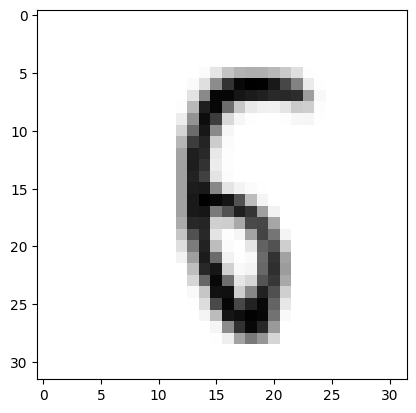

The target label is 6.
The prediction label is 5.


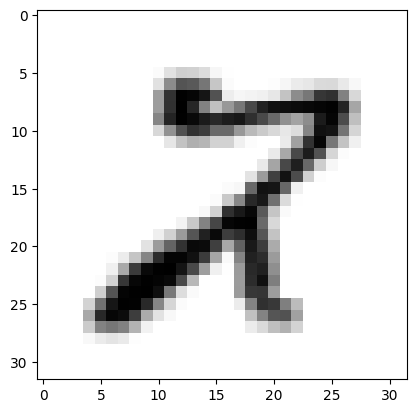

The target label is 2.
The prediction label is 7.


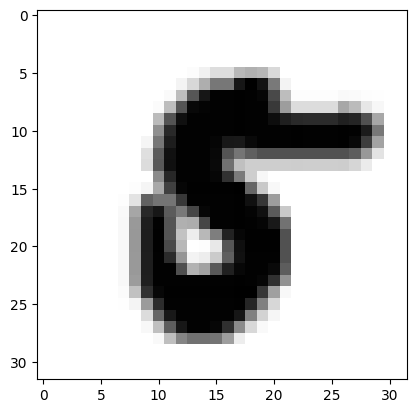

The target label is 5.
The prediction label is 8.


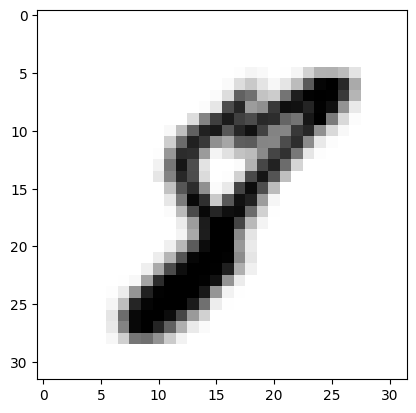

The target label is 8.
The prediction label is 9.


In [ ]:
plt.figure()
for i, w_idx in enumerate(wrong_idx[batch_num]):
    plt.imshow(Xs[w_idx].numpy().squeeze(), cmap='gray_r')
    plt.show()
    print(f"The target label is {targets[w_idx]}.")
    print(f"The prediction label is {ypreds[w_idx][0]}.")

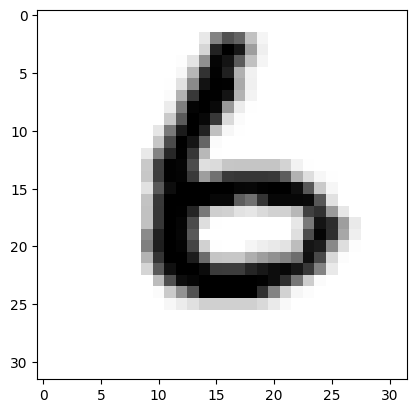

The target label is 6.
The prediction label is 6.


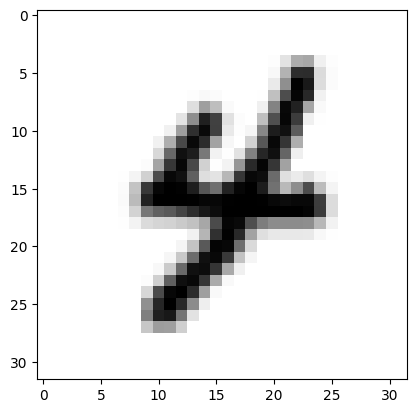

The target label is 4.
The prediction label is 4.


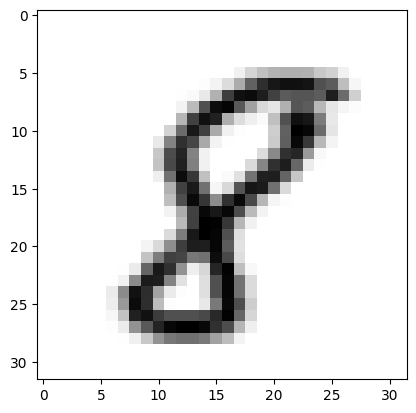

The target label is 8.
The prediction label is 8.


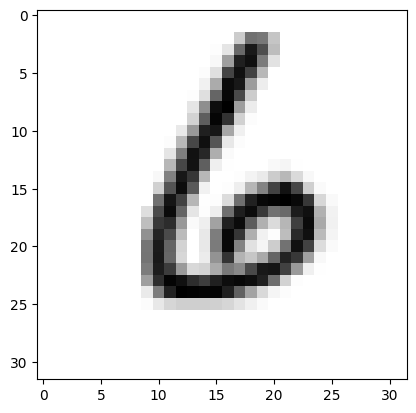

The target label is 6.
The prediction label is 6.


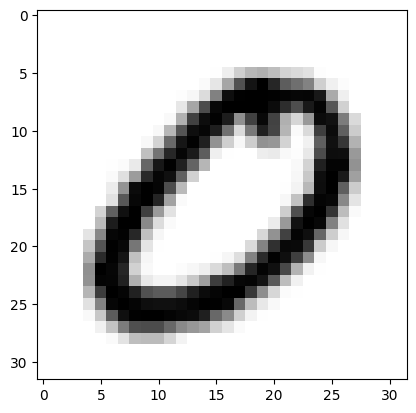

The target label is 0.
The prediction label is 0.


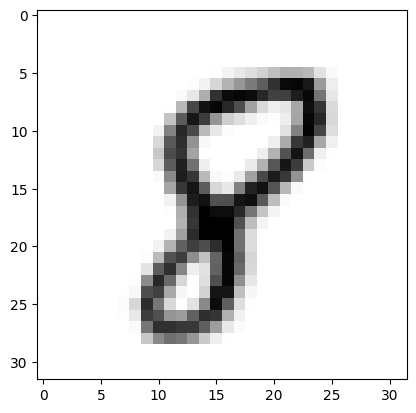

The target label is 8.
The prediction label is 8.


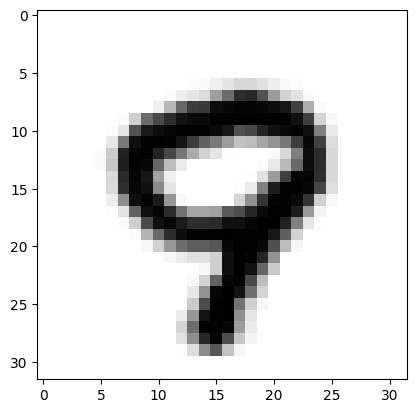

The target label is 9.
The prediction label is 9.


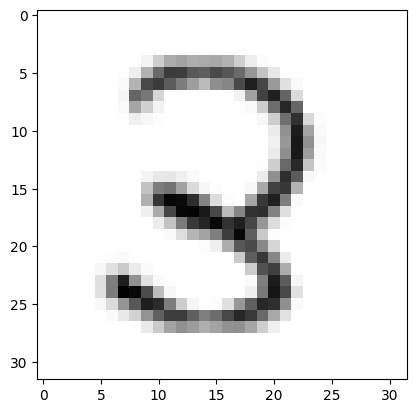

The target label is 3.
The prediction label is 3.


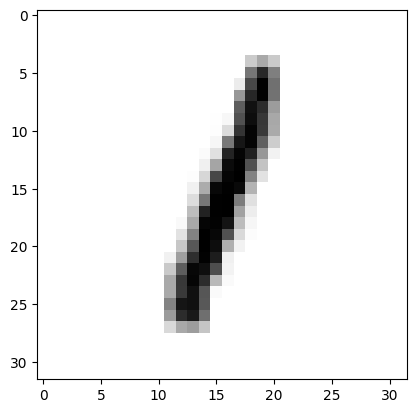

The target label is 1.
The prediction label is 1.


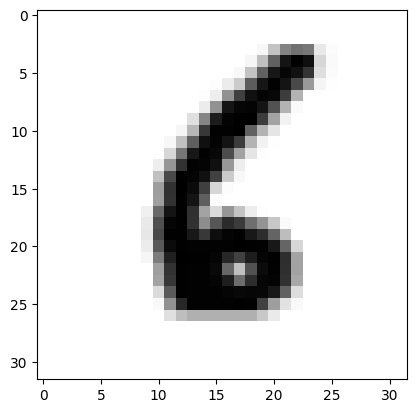

The target label is 6.
The prediction label is 6.


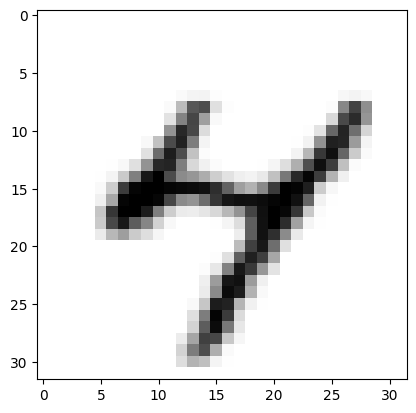

The target label is 4.
The prediction label is 4.


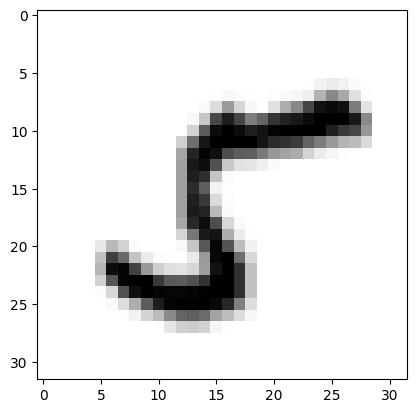

The target label is 5.
The prediction label is 5.


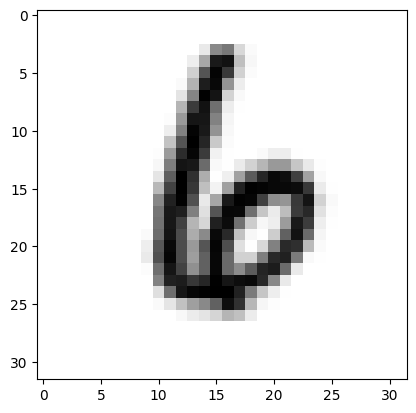

The target label is 6.
The prediction label is 6.


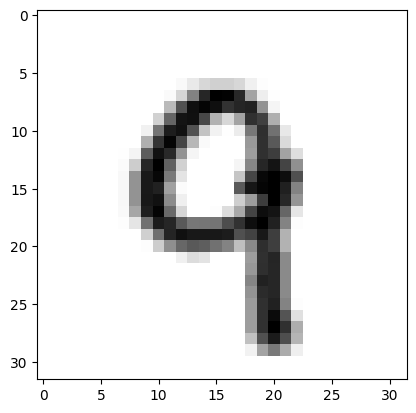

The target label is 9.
The prediction label is 9.


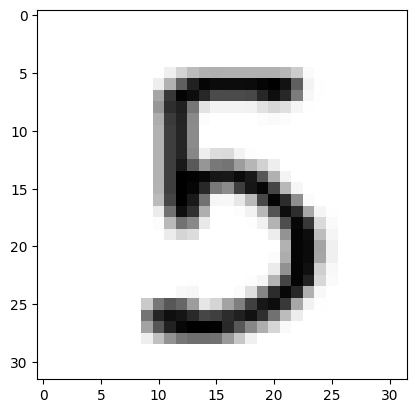

The target label is 5.
The prediction label is 5.


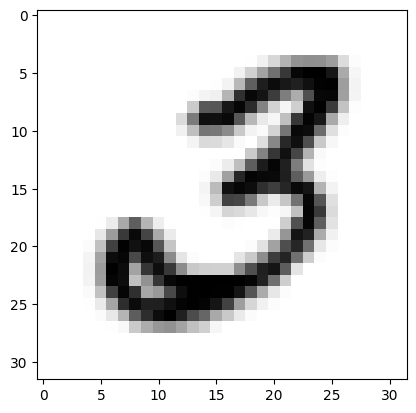

The target label is 3.
The prediction label is 3.


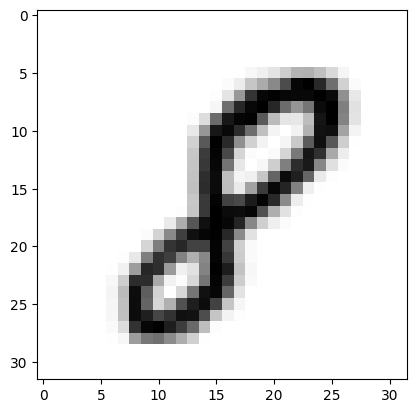

The target label is 8.
The prediction label is 8.


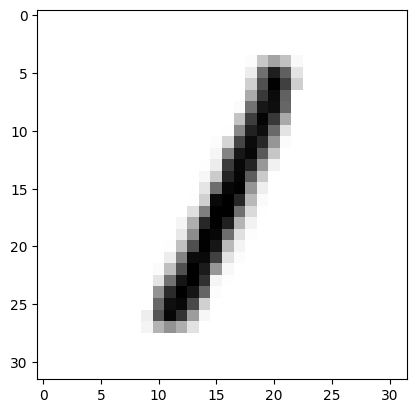

The target label is 1.
The prediction label is 1.


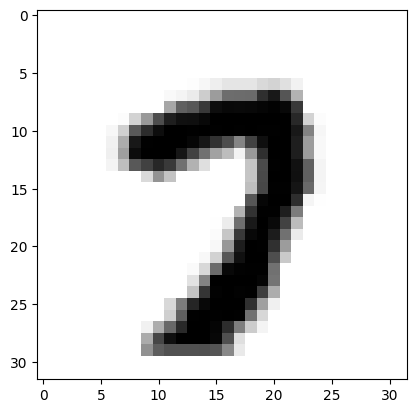

The target label is 7.
The prediction label is 7.


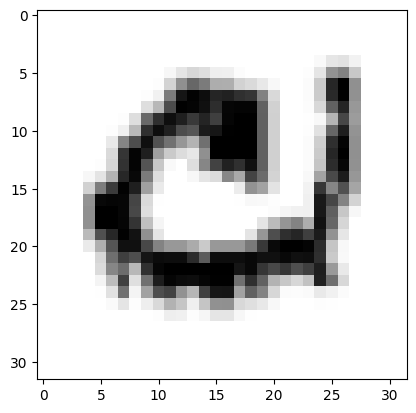

The target label is 0.
The prediction label is 0.


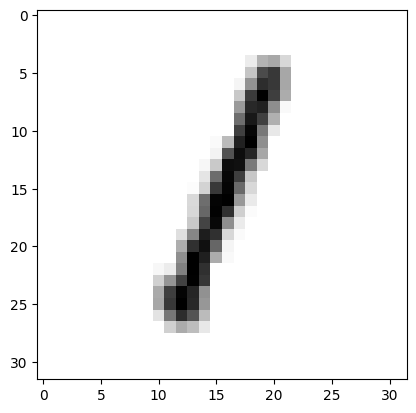

The target label is 1.
The prediction label is 1.


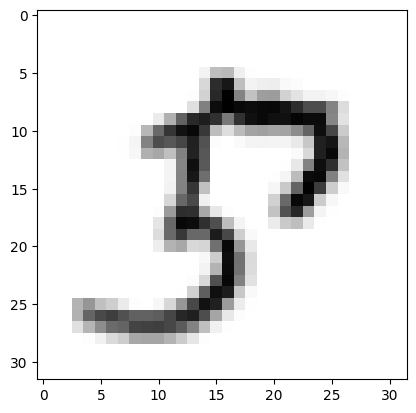

The target label is 5.
The prediction label is 5.


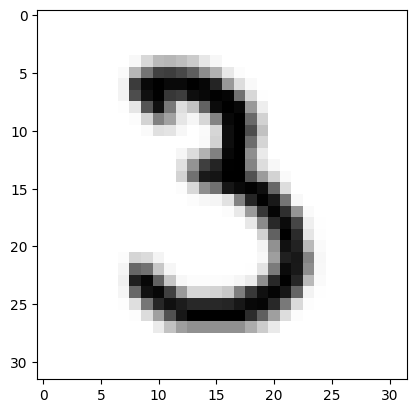

The target label is 3.
The prediction label is 3.


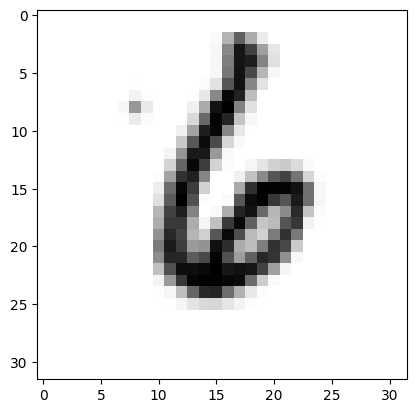

The target label is 6.
The prediction label is 6.


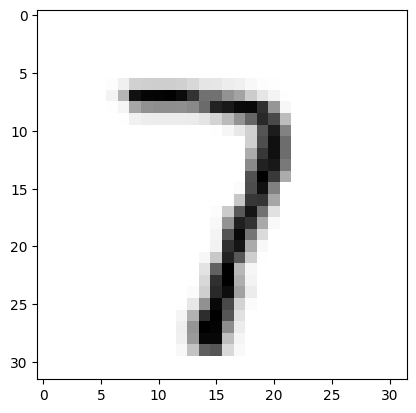

The target label is 7.
The prediction label is 7.


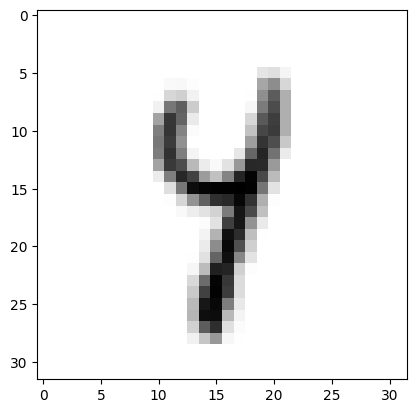

The target label is 4.
The prediction label is 4.


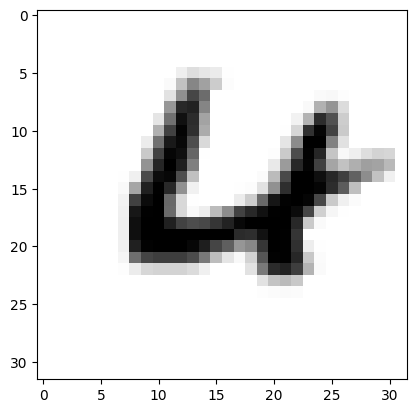

The target label is 4.
The prediction label is 4.


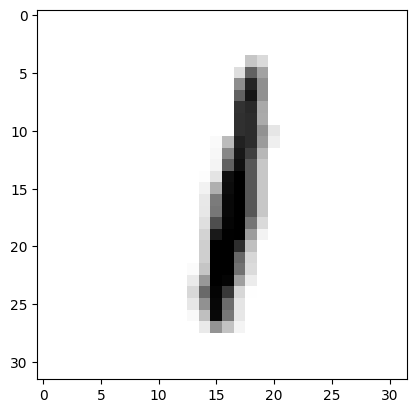

The target label is 1.
The prediction label is 1.


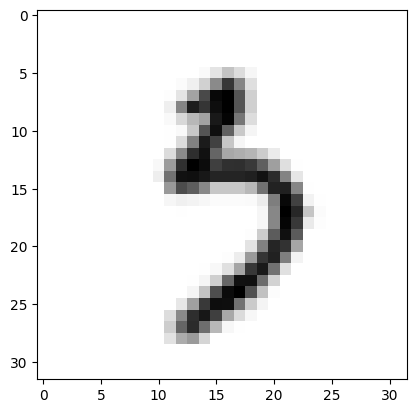

The target label is 3.
The prediction label is 3.


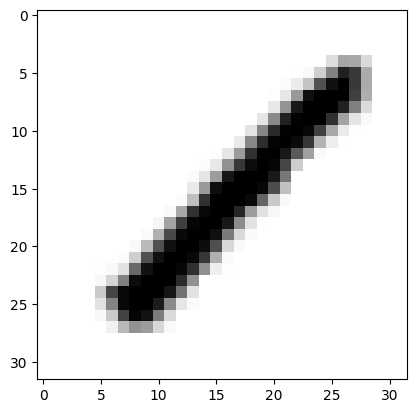

The target label is 1.
The prediction label is 1.


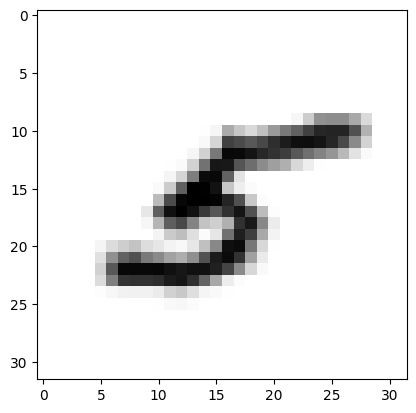

The target label is 5.
The prediction label is 5.


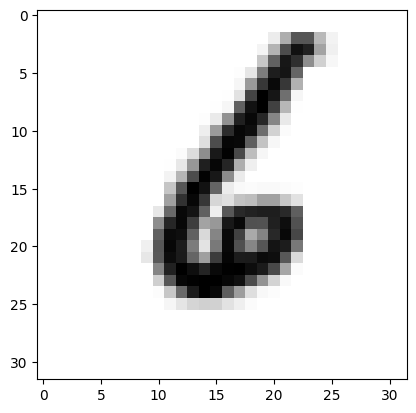

The target label is 6.
The prediction label is 6.


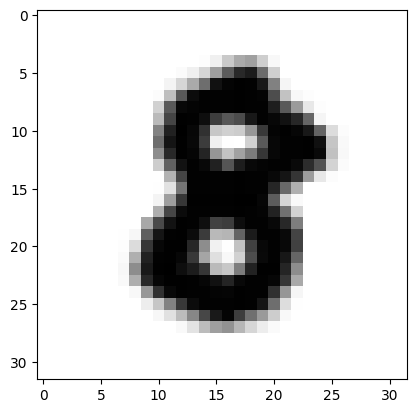

The target label is 8.
The prediction label is 8.


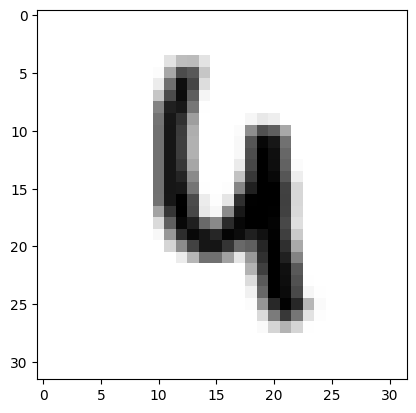

The target label is 4.
The prediction label is 4.


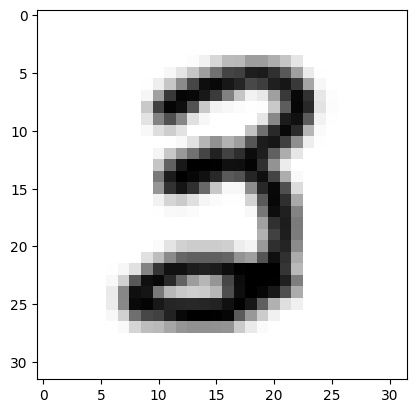

The target label is 3.
The prediction label is 3.


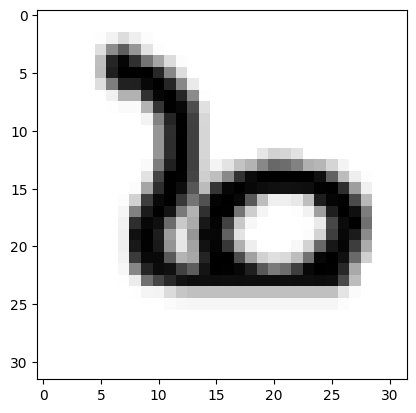

The target label is 6.
The prediction label is 6.


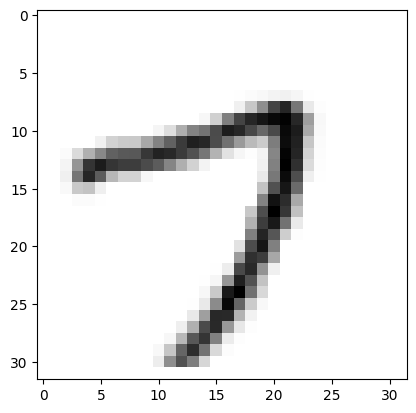

The target label is 7.
The prediction label is 7.


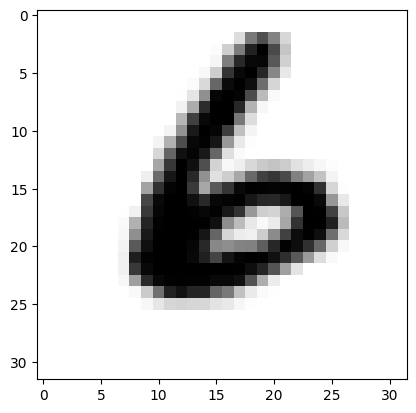

The target label is 6.
The prediction label is 6.


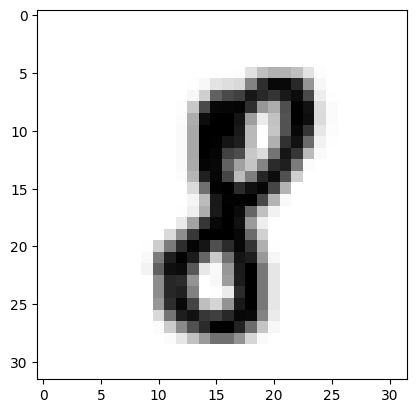

The target label is 8.
The prediction label is 8.


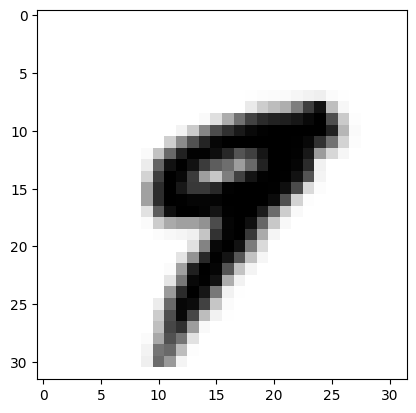

The target label is 9.
The prediction label is 9.


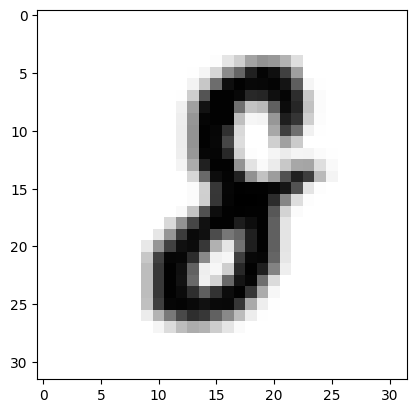

The target label is 8.
The prediction label is 8.


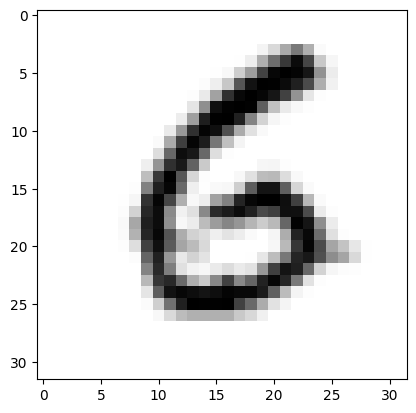

The target label is 6.
The prediction label is 6.


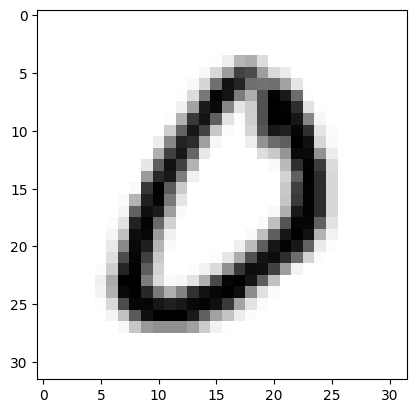

The target label is 0.
The prediction label is 0.


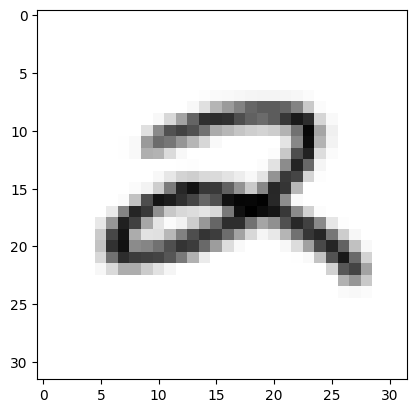

The target label is 2.
The prediction label is 2.


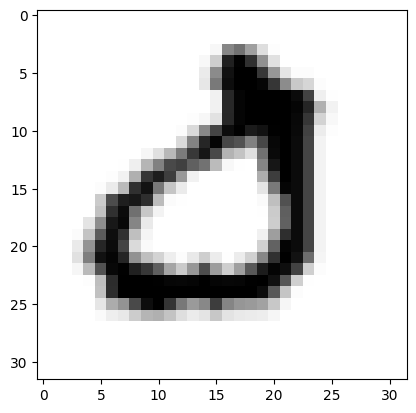

The target label is 0.
The prediction label is 0.


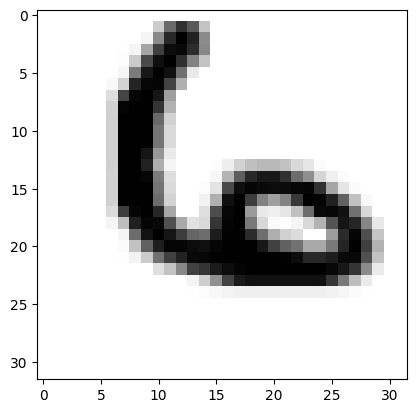

The target label is 6.
The prediction label is 6.


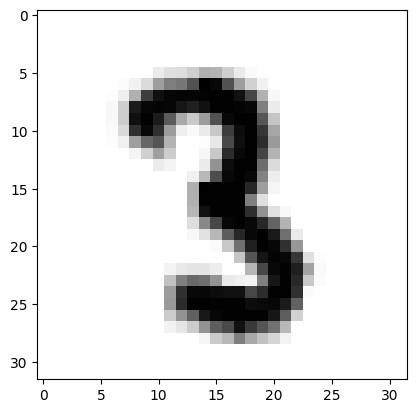

The target label is 3.
The prediction label is 3.


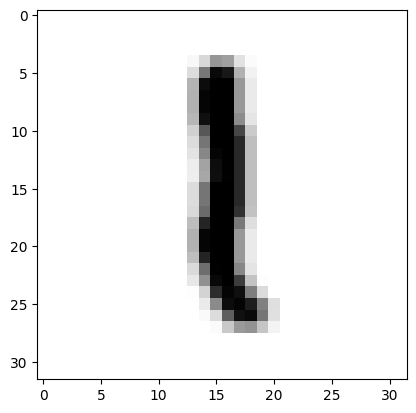

The target label is 1.
The prediction label is 1.


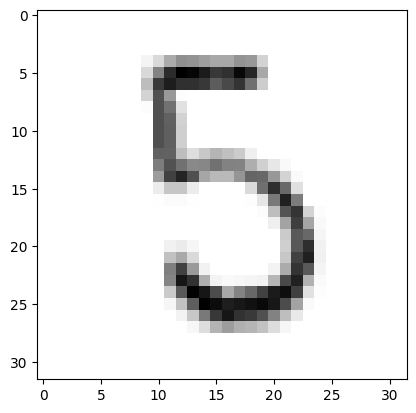

The target label is 5.
The prediction label is 5.


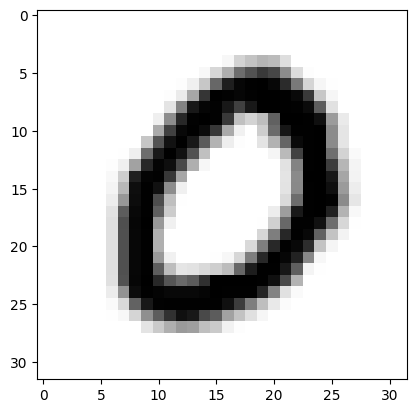

The target label is 0.
The prediction label is 0.


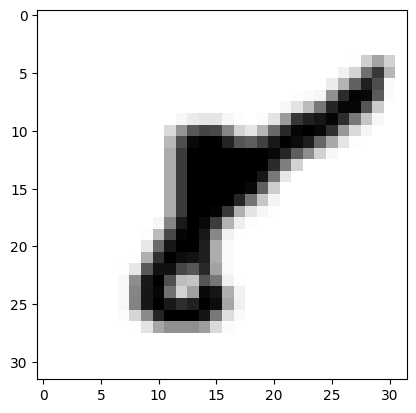

The target label is 8.
The prediction label is 8.


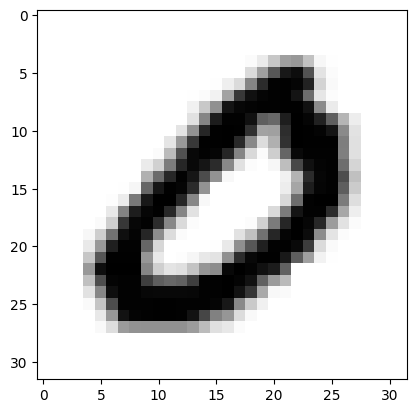

The target label is 0.
The prediction label is 0.


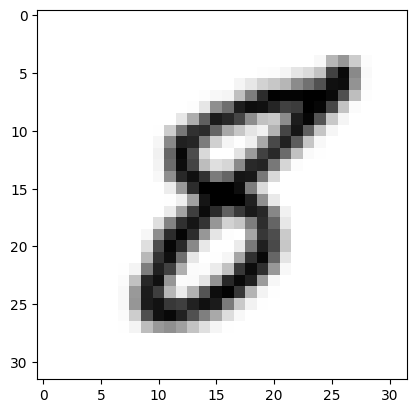

The target label is 8.
The prediction label is 8.


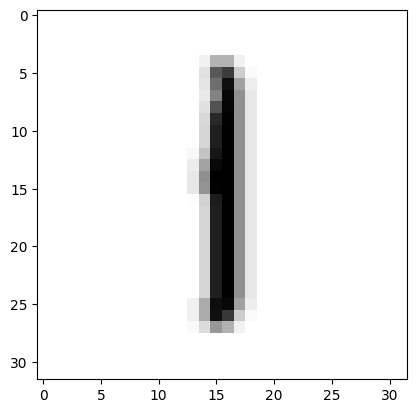

The target label is 1.
The prediction label is 1.


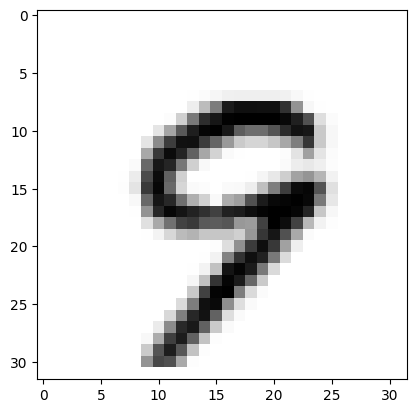

The target label is 9.
The prediction label is 9.


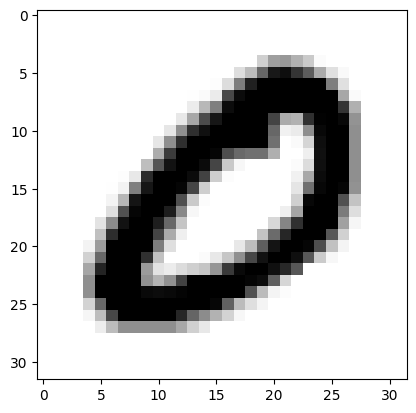

The target label is 0.
The prediction label is 0.


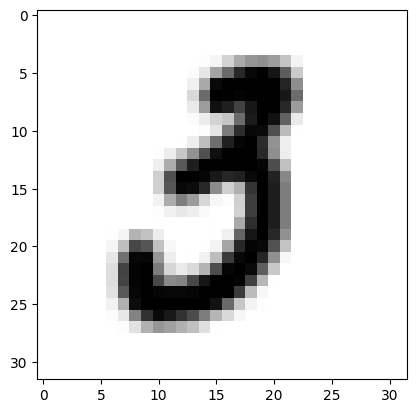

The target label is 3.
The prediction label is 3.


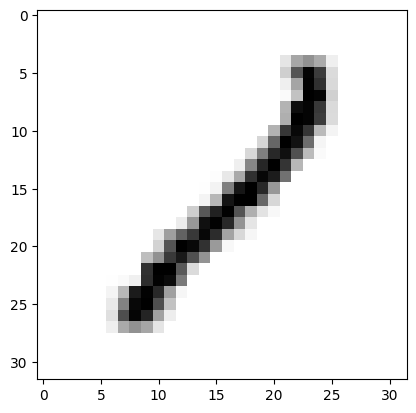

The target label is 1.
The prediction label is 1.


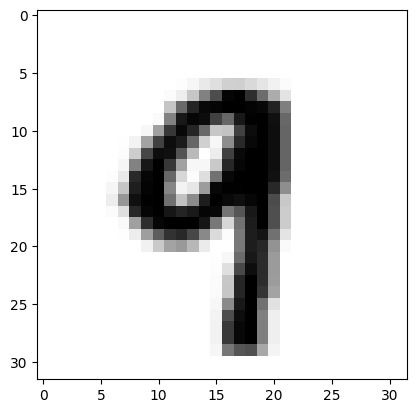

The target label is 9.
The prediction label is 9.


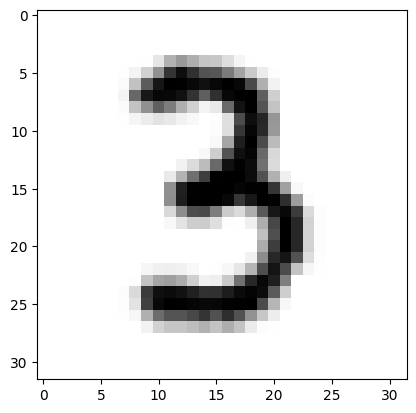

The target label is 3.
The prediction label is 3.


In [ ]:
plt.figure()
for i, c_idx in enumerate(correct_idx[batch_num]):
    plt.imshow(Xs[c_idx].numpy().squeeze(), cmap='gray_r')
    plt.show()
    print(f"The target label is {targets[c_idx]}.")
    print(f"The prediction label is {ypreds[c_idx][0]}.")